In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict
import json
import os
import time
import random
import networkx as nx
import matplotlib.pyplot as plt
import ast
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from keras import layers, Model
from keras.models import Model
from keras.layers import Input
from spektral.layers import GCNConv
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.initializers import RandomNormal
import itertools
import math
import gc
# from tensorflow.keras import mixed_precisions

# mixed_precision.set_global_policy("mixed_float16")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 4

search_space = {
    "hidden_dim": [100],
    "lr": [0.01]
    # "lr": [0.001] # ORIGINAL LR VALUE
}



"""
the fuse function and the score passing -> fuse_lsg_with_wgig
threshold value -> run_hyperparam_grid
"""

os.environ["TF_DETERMINISTIC_OPS"] = "1"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent TensorFlow from reserving all GPU memory upfront
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"TensorFlow is configured to use {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(f"Error while setting GPU configuration: {e}")
else:
    print("No GPU found. Running on CPU.")

# Now it is safe to perform any TensorFlow operations
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

CLICKS_PATH = "D:/code/E-GNN/dataset-diginetica/train-item-views.csv"
TEST_PATH = "D:/code/E-GNN//dataset-diginetica/train-queries.csv"

TRAIN_CLICKS_PATH = "D:/code/E-GNN/dataset-diginetica/train-clicks.csv"
TRAIN_QUERIES_PATH = "D:/code/E-GNN/dataset-diginetica/train-queries.csv"
TRAIN_ITEM_VIEW_PATH = "D:/code/E-GNN/dataset-diginetica/train-item-views.csv"

WGIG_PATH = "D:/code/E-GNN/wgig_matrix_diginetica.json"
SESSION_LSGS = "D:/code/E-GNN/session_lsgs_diginetica.json"
TEST_SESSION_LSGS = "D:/code/E-GNN/test_session_lsgs_diginetica.json"

UNIQUE_ITEMS_PATH = "D:/code/E-GNN/unique_items_diginetica.json"
ITEM_TO_IDX_PATH = "D:/code/E-GNN//item_to_idx_diginetica.json"
IDX_TO_ITEM_PATH = "D:/code/E-GNN/idx_to_item_diginetica.json"

clicks_df = pd.DataFrame()


def load_diginetica_sessions_subset(views_path, top_n_items=1000):
    

    views = pd.read_csv(views_path, delimiter=';')

    print(f"originally views shape = {views.shape}")

    # Rename and sort
    views = views.rename(columns={"sessionId": "session_id", "itemId": "item", "timeframe": "timestamp"})
    views = views.sort_values(by=["session_id", "timestamp"])

    # Drop short sessions (≤ 1)
    session_lengths = views.groupby('session_id').size()
    valid_sessions = session_lengths[session_lengths > 1].index
    views = views[views['session_id'].isin(valid_sessions)]

    # Count item frequencies
    item_counts = views['item'].value_counts()

    # Select top-N most frequent items
    top_items = set(item_counts.head(top_n_items).index)

    # Filter views to sessions where **all items** are in top-N
    session_to_items = views.groupby('session_id')['item'].apply(set)
    valid_sessions = session_to_items[session_to_items.apply(lambda items: items.issubset(top_items))].index

    # Apply session filter
    views = views[views['session_id'].isin(valid_sessions)]

    print(f"filtered views shape = {views.shape} (top-{top_n_items} items only)")

    return views



def load_diginetica_sessions(views_path, purchases_path):
    views = pd.read_csv(views_path, delimiter=';')
    # purchases = pd.read_csv(purchases_path, delimiter=';')

    print(f"originally views shape = {views.shape}")


    # Keep only sessions that ended in a purchase
    # purchase_sessions = set(purchases['sessionId'].unique())
    # views = views[views['sessionId'].isin(purchase_sessions)]

    # print(f"after purchase filter views shape = {views.shape}")


    # Filter low-frequency items
    item_counts = views['itemId'].value_counts()
    views = views[views['itemId'].isin(item_counts[item_counts >= 5].index)]

    # Drop short sessions
    session_lengths = views.groupby('sessionId').size()
    valid_sessions = session_lengths[session_lengths > 1].index
    views = views[views['sessionId'].isin(valid_sessions)]

    # Final cleanup
    views = views.sort_values(by=['sessionId', 'timeframe'])
    views = views.rename(columns={"sessionId": "session_id", "itemId": "item", "timeframe": "timestamp"})

    print(f"final views shape = {views.shape}")

    return views


def create_WGIG(df):
    df = df.sort_values(by=['session_id', 'timestamp'])
    transition_counts = defaultdict(int)

    for session_id, group in df.groupby('session_id'):
        items = group['item'].tolist()
        for i in range(len(items) - 1):
            transition_counts[(items[i], items[i + 1])] += 1

    wgig = {}
    for (i, j), count_ij in transition_counts.items():
        count_ji = transition_counts.get((j, i), 0)
        total = count_ij + count_ji
        if total > 0:
            wgig[(i, j)] = count_ij / total

    return wgig

def create_lsg(session_items):
    edge_counts = defaultdict(int)
    out_degree = defaultdict(int)

    for i in range(len(session_items) - 1):
        src, tgt = session_items[i], session_items[i + 1]
        if src != tgt:
            edge_counts[(src, tgt)] += 1
            out_degree[src] += 1

    return {
        (i, j): count / out_degree[i]
        for (i, j), count in edge_counts.items()
    }

def create_session_lgs(df):
    session_lsgs = {}
    for session_id, group in df.groupby('session_id'):
        items = group.sort_values('timestamp')['item'].tolist()
        if len(items) > 1:
            session_lsgs[session_id] = create_lsg(items)
    return session_lsgs


def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
    """
    base version - original fusion function, binary pass
    """
    fused_edges = {}
    session_set = set(session_items)

    # Always include LSG edges
    for (i, j) in lsg:
        fused_edges[(i, j)] = 1.0

    # Expand with WGIG edges based on session_items
    for (i, j), w_ij in wgig.items():
        if i not in session_set:
            continue  # Only expand from session items

        a_l_ij = 1.0 if (i, j) in lsg else 0.0
        fused_score = w_ij * (a_l_ij + w_ij)

        if (i, j) not in lsg and fused_score >= threshold:
            fused_edges[(i, j)] = 1.0

    return fused_edges


# def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
#     """
#     original fusion function, passing score 
#     """
#     fused_edges = {}
#     session_set = set(session_items)

#     # Always include LSG edges
#     for (i, j) in lsg:
#         fused_edges[(i, j)] = 1.0

#     # Expand with WGIG edges based on session_items
#     for (i, j), w_ij in wgig.items():
#         if i not in session_set:
#             continue  # Only expand from session items

#         a_l_ij = 1.0 if (i, j) in lsg else 0.0
#         fused_score = w_ij * (a_l_ij + w_ij)

#         if (i, j) not in lsg and fused_score >= threshold:
#             fused_edges[(i, j)] = fused_score

#     return fused_edges


# def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
#     """
#     MAX fusion function , binary pass 
#     """
#     fused_edges = {}
#     session_set = set(session_items)

#     # Always include LSG edges
#     for (i, j) in lsg:
#         fused_edges[(i, j)] = 1.0

#     # Expand with WGIG edges based on session_items
#     for (i, j), w_ij in wgig.items():
#         if i not in session_set:
#             continue  # Only expand from session items

#         a_l_ij = 1.0 if (i, j) in lsg else 0.0
#         fused_score =  max(a_l_ij + w_ij)

#         if (i, j) not in lsg and fused_score >= threshold:
#             fused_edges[(i, j)] = 1

#     return fused_edges

# def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
#     """
#     MAX fusion function , score pass 
#     """
#     fused_edges = {}
#     session_set = set(session_items)

#     # Always include LSG edges
#     for (i, j) in lsg:
#         fused_edges[(i, j)] = 1.0

#     # Expand with WGIG edges based on session_items
#     for (i, j), w_ij in wgig.items():
#         if i not in session_set:
#             continue  # Only expand from session items

#         a_l_ij = 1.0 if (i, j) in lsg else 0.0
#         fused_score =  max(a_l_ij + w_ij)

#         if (i, j) not in lsg and fused_score >= threshold:
#             fused_edges[(i, j)] = fused_score

#     return fused_edges




# def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
#     """
#     linear combo fusion function, binary pass
#     """
#     alpha = 0.5
#     beta = 0.5

#     fused_edges = {}
#     session_set = set(session_items)

#     # Always include LSG edges
#     for (i, j) in lsg:
#         fused_edges[(i, j)] = 1.0

#     # Expand with WGIG edges based on session_items
#     for (i, j), w_ij in wgig.items():
#         if i not in session_set:
#             continue  # Only expand from session items

#         a_l_ij = 1.0 if (i, j) in lsg else 0.0
#         fused_score = alpha * a_l_ij +  beta *w_ij

#         if (i, j) not in lsg and fused_score >= threshold:
#             fused_edges[(i, j)] = 1.0

#     return fused_edges




# def fuse_lsg_with_wgig(lsg, wgig, session_items, threshold):
#     """
#     linear combo fusion function, scoring pass
#     """
#     alpha = 0.5
#     beta = 0.5

#     fused_edges = {}
#     session_set = set(session_items)

#     # Always include LSG edges
#     for (i, j) in lsg:
#         fused_edges[(i, j)] = 1.0

#     # Expand with WGIG edges based on session_items
#     for (i, j), w_ij in wgig.items():
#         if i not in session_set:
#             continue  # Only expand from session items

#         a_l_ij = 1.0 if (i, j) in lsg else 0.0
#         fused_score = alpha * a_l_ij +  beta *w_ij

#         if (i, j) not in lsg and fused_score >= threshold:
#             fused_edges[(i, j)] = fused_score

#     return fused_edges






class GRUUpdateLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.H  = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Wz = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Uz = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Wr = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Ur = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Wh = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.Uh = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))

    def call(self, x, degree_features, agg_neighbors):
        d = self.H(degree_features)

        z = tf.nn.sigmoid(self.Wz(d) + self.Uz(x))
        r = tf.nn.sigmoid(self.Wr(d) + self.Ur(x))
        h_tilde = tf.nn.tanh(self.Wh(d) + self.Uh(r * agg_neighbors))
        h = (1 - z) * x + z * h_tilde
        return h


class EGNNLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear = layers.Dense(hidden_dim, use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.gru_update = GRUUpdateLayer(hidden_dim)

    def call(self, x, degree_features, adj_matrix):
        if isinstance(adj_matrix, tf.SparseTensor):
            agg_neighbors = tf.sparse.sparse_dense_matmul(adj_matrix, self.linear(x))
        else:
            agg_neighbors = tf.matmul(adj_matrix, self.linear(x))
        return self.gru_update(x, degree_features, agg_neighbors)


class EGNNModel(Model):
    def __init__(self, num_items, hidden_dim):
        super().__init__()
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=hidden_dim,
            embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)
        )

        self.egnn_layer = EGNNLayer(hidden_dim)

        self.W1 = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.W2 = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))
        self.q  = self.add_weight(shape=(hidden_dim, 1), initializer=RandomNormal(mean=0.0, stddev=0.01), trainable=True)
        self.c  = self.add_weight(shape=(hidden_dim,), initializer='zeros', trainable=True)
        self.W3 = layers.Dense(hidden_dim, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))

    def call(self, session_item_ids, degree_features, last_item_index, adj_matrix, training=False):
        x = self.item_embedding(session_item_ids)  # [N, d]
        x = self.egnn_layer(x, degree_features, adj_matrix)

        last_item_emb = tf.expand_dims(tf.gather(x, last_item_index[0]), axis=0)  # [1, d]

        attn_input = tf.nn.sigmoid(self.W1(last_item_emb) + self.W2(x) + self.c)  # [N, d]
        attn_scores = tf.squeeze(tf.matmul(attn_input, self.q), axis=-1)          # [N]
        alpha = tf.nn.softmax(attn_scores, axis=-1)                               # [N]

        global_pref = tf.reduce_sum(x * tf.expand_dims(alpha, axis=-1), axis=0, keepdims=True)  # [1, d]
        session_rep = tf.concat([last_item_emb, global_pref], axis=-1)                          # [1, 2d]
        session_rep = self.W3(session_rep)                                                      # [1, d]

        logits = tf.matmul(session_rep, self.item_embedding.weights[0], transpose_b=True)       # [1, num_items]
        return logits


def train_batch(model, optimizer, loss_fn, batch_inputs, batch_degrees, batch_last_idx, batch_adjs, batch_targets):
        with tf.GradientTape() as tape:
            logits_batch = []
            for session_item_ids, degree_features, last_item_index, adj_matrix in zip(
                batch_inputs, batch_degrees, batch_last_idx, batch_adjs
            ):
                logits = model(session_item_ids, degree_features, last_item_index, adj_matrix, training=True)
                logits_batch.append(logits)
            logits_batch = tf.concat(logits_batch, axis=0)
            targets = tf.concat(batch_targets, axis=0)
            loss = loss_fn(targets, tf.cast(logits_batch, tf.float32))

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


# Preprocessing function
def graph_to_tensor_with_adj(fused_edges, embedding_dim):
    if not fused_edges:
        return None, None, None, None

    unique_items = sorted(set(u for u, _ in fused_edges) | set(v for _, v in fused_edges))
    node_map = {item: idx for idx, item in enumerate(unique_items)}
    N = len(unique_items)

    in_deg = np.zeros(N, dtype=np.float32)
    out_deg = np.zeros(N, dtype=np.float32)
    rows, cols, values = [], [], []

    for (u, v), weight in fused_edges.items():
        i, j = node_map[u], node_map[v]
        out_deg[i] += weight
        in_deg[j] += weight
        rows.append(i)
        cols.append(j)
        values.append(weight)

    degree_features = np.stack([in_deg, out_deg], axis=1)  # → shape [N, 2]

    session_indices = [item_to_idx[item] for item in unique_items]
    session_item_ids = tf.constant(session_indices, dtype=tf.int32)

    degree_features = tf.convert_to_tensor(degree_features, dtype=tf.float32)
    adj = tf.sparse.SparseTensor(indices=np.array(list(zip(rows, cols))),
                                 values=np.array(values, dtype=np.float32),
                                 dense_shape=[N, N])
    adj = tf.sparse.reorder(adj)

    return session_item_ids, degree_features, adj, node_map



def train_egnn_model_tf(session_to_items, session_lsgs, wgig, model, optimizer,
                        item_to_idx, fuse_fn, graph_to_tensor_fn,
                        save_path="./models/egnn_ep", num_epochs=5,
                        epoch_start=0, batch_size=100, embedding_dim=64, curr_threshold=None):

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    sessions = sorted(session_lsgs.keys())
    num_sessions = len(sessions)


    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0
        num_examples = 0
        random.shuffle(sessions)
        print(f"\n📘 Epoch {epoch_start + epoch + 1}/{epoch_start + num_epochs} ({num_sessions} sessions)")

        batch_inputs, batch_degrees, batch_adjs, batch_last_idx, batch_targets = [], [], [], [], []

        # Skipped counters
        skipped_short_session = 0
        skipped_target_missing = 0
        skipped_empty_fused = 0
        skipped_tensor_failure = 0
        skipped_missing_last_node = 0

        for idx, session_id in enumerate(sessions):
            item_seq = session_to_items.get(session_id)
            if not item_seq or len(item_seq) < 2:
                skipped_short_session += 1
                continue

            for i in range(1, len(item_seq)):
                session_input = item_seq[:i]
                target_item = item_seq[i]
                last_item = session_input[-1]

                if target_item not in item_to_idx:
                    skipped_target_missing += 1
                    continue
                target_idx = item_to_idx[target_item]

                fused = fuse_fn(session_lsgs[session_id], wgig, session_input, threshold=curr_threshold)
                if not fused:
                    skipped_empty_fused += 1
                    continue

                result = graph_to_tensor_fn(fused, embedding_dim)
                if result is None:
                    skipped_tensor_failure += 1
                    continue
                session_item_ids, degree_features, adj_matrix, node_map = result

                if not node_map or last_item not in node_map:
                    skipped_missing_last_node += 1
                    continue

                last_item_index = tf.constant([node_map[last_item]])
                target_tensor = tf.constant([target_idx])

                batch_inputs.append(session_item_ids)
                batch_degrees.append(degree_features)
                batch_adjs.append(adj_matrix)
                batch_last_idx.append(last_item_index)
                batch_targets.append(target_tensor)

                if len(batch_inputs) >= batch_size:
                    loss = train_batch(model, optimizer, loss_fn, batch_inputs, batch_degrees, batch_last_idx, batch_adjs, batch_targets)
                    total_loss += loss.numpy()
                    num_examples += len(batch_inputs)
                    batch_inputs, batch_degrees, batch_adjs, batch_last_idx, batch_targets = [], [], [], [], []
                    if num_examples % 10000 == 0:
                        print(f"loaded so far, num_examples = {num_examples}, up to seesion no. {idx}")

                gc.collect() 

        # Process remaining batch
        if batch_inputs:
            loss = train_batch(model, optimizer, loss_fn, batch_inputs, batch_degrees, batch_last_idx, batch_adjs, batch_targets)
            total_loss += loss.numpy()
            num_examples += len(batch_inputs)

        avg_loss = total_loss / max(num_examples, 1)
        print(f"✅ Epoch {epoch_start + epoch + 1} - Avg Loss: {avg_loss:.4f}")
        print(f"⏱️ Time for epoch: {time.time() - start_time:.2f} seconds")

        print(f"🚫 Skipped counts:")
        print(f"   Short sessions           : {skipped_short_session}")
        print(f"   Target item not in vocab: {skipped_target_missing}")
        print(f"   Empty fused graph        : {skipped_empty_fused}")
        print(f"   Graph tensor build failed: {skipped_tensor_failure}")
        print(f"   Last item missing in map : {skipped_missing_last_node}")

        weight_path = f"{save_path}{epoch_start + epoch + 1}.weights.h5"
        model.save_weights(weight_path)
        print(f"💾 Model weights saved to {weight_path}")

    return model




def evaluate_egnn_model(model, eval_name, session_to_items, session_lsgs, wgig, item_to_idx,
                        fuse_fn, graph_to_tensor_fn, k=20, embedding_dim=64, curr_threshold=None):
    correct = 0
    total = 0
    start_time = time.time()

    # Skip counters
    skipped_short_session = 0
    skipped_missing_target = 0
    skipped_missing_lsg = 0
    skipped_empty_fused = 0
    skipped_tensor_failure = 0
    skipped_missing_last_node = 0

    for session_id, item_seq in session_to_items.items():
        if len(item_seq) < 2:
            skipped_short_session += 1
            continue

        session_input = item_seq[:-1]
        target_item = item_seq[-1]
        last_item = session_input[-1]

        if target_item not in item_to_idx:
            skipped_missing_target += 1
            continue
        target_idx = item_to_idx[target_item]

        lsg = session_lsgs.get(session_id)
        if lsg is None:
            skipped_missing_lsg += 1
            continue

        fused = fuse_fn(lsg, wgig, session_input, threshold=curr_threshold)
        if not fused:
            skipped_empty_fused += 1
            continue

        result = graph_to_tensor_fn(fused, embedding_dim)
        if result is None:
            skipped_tensor_failure += 1
            continue
        session_item_ids, degree_features, adj_matrix, node_map = result

        if not node_map or last_item not in node_map:
            skipped_missing_last_node += 1
            continue

        last_item_index = tf.constant([node_map[last_item]])
        logits = model(session_item_ids, degree_features, last_item_index, adj_matrix, training=False)

        top_k = tf.math.top_k(logits, k=k).indices.numpy().flatten()
        if target_idx in top_k:
            correct += 1
        total += 1

    recall = correct / total if total > 0 else 0.0
    elapsed = time.time() - start_time

    print(f"{eval_name}")
    print(f"✅ Top-{k} Recall: {recall:.4f} ({correct}/{total})")
    print(f"⏱️ Evaluation time: {elapsed:.2f} seconds")

    print("🚫 Skipped during evaluation:")
    print(f"   Short sessions           : {skipped_short_session}")
    print(f"   Target item not in vocab: {skipped_missing_target}")
    print(f"   Missing local graph      : {skipped_missing_lsg}")
    print(f"   Empty fused graph        : {skipped_empty_fused}")
    print(f"   Tensor conversion failed: {skipped_tensor_failure}")
    print(f"   Last item not in map     : {skipped_missing_last_node}")
    print("\n---------------------------")
    return recall



def evaluate_across_epochs(model_prefix, hidden_dim, lr, threshold, num_epochs):
    model_paths = [
        f"./E-GNN/models/{model_prefix}{epoch}.weights.h5"
        for epoch in range(1, num_epochs + 1)
    ]

    train_recalls, val_recalls, test_recalls = [], [], []

    for epoch, path in enumerate(model_paths, start=1):
        if not os.path.exists(path):
            print(f"Skipping missing checkpoint: {path}")
            continue

        # Initialize model and dummy call to build weights
        model = EGNNModel(num_items=num_items, hidden_dim=hidden_dim)
        dummy_ids = tf.constant([0, 1], dtype=tf.int32)
        dummy_degrees = tf.zeros((2, 2), dtype=tf.float32)
        dummy_index = tf.constant([1], dtype=tf.int32)
        dummy_adj = tf.sparse.SparseTensor(indices=[[0, 1], [1, 0]],
                                           values=[1.0, 1.0],
                                           dense_shape=[2, 2])
        dummy_adj = tf.sparse.reorder(dummy_adj)
        _ = model(dummy_ids, dummy_degrees, dummy_index, dummy_adj, training=False)
        model.load_weights(path)

        print(f"\n📊 Evaluating Epoch {epoch}...")

        train_recall = evaluate_egnn_model(
            model=model,
            eval_name=f"Train (Epoch {epoch})",
            session_to_items=train_session_to_items,
            session_lsgs=train_lsgs,
            wgig=wgig,
            item_to_idx=item_to_idx,
            fuse_fn=fuse_lsg_with_wgig,
            graph_to_tensor_fn=graph_to_tensor_with_adj,
            curr_threshold=threshold
        )
        val_recall = evaluate_egnn_model(
            model=model,
            eval_name=f"Val (Epoch {epoch})",
            session_to_items=val_session_to_items,
            session_lsgs=val_lsgs,
            wgig=wgig,
            item_to_idx=item_to_idx,
            fuse_fn=fuse_lsg_with_wgig,
            graph_to_tensor_fn=graph_to_tensor_with_adj,
            curr_threshold=threshold
        )
        test_recall = evaluate_egnn_model(
            model=model,
            eval_name=f"Test (Epoch {epoch})",
            session_to_items=test_session_to_items,
            session_lsgs=test_lsgs,
            wgig=wgig,
            item_to_idx=item_to_idx,
            fuse_fn=fuse_lsg_with_wgig,
            graph_to_tensor_fn=graph_to_tensor_with_adj,
            curr_threshold=threshold
        )

        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        test_recalls.append(test_recall)

    return train_recalls, val_recalls, test_recalls


def build_model_and_optimizer(num_items, hidden_dim, lr, num_training_steps_per_epoch):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=3 * num_training_steps_per_epoch,
        decay_rate=0.1,
        staircase=True
    )

    model = EGNNModel(num_items=num_items, hidden_dim=hidden_dim)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
    return model, optimizer


def run_hyperparam_grid(search_space, run_fn):

     ##### threshold #####
    curr_threshold = 0.5
    # curr_threshold = 0.5


    results = []
    keys = list(search_space.keys())
    for values in itertools.product(*search_space.values()):
        params = dict(zip(keys, values))
        print("\n🔧 Running trial with params:", params)
        result = run_fn(params ,curr_threshold)
        results.append(result)
    return results



def run_trial(params, curr_threshold):
    hidden_dim = params["hidden_dim"]
    lr = params["lr"]

    prefix = f"egnn_ep"
    folder = "./E-GNN/models/"
    pattern = re.compile(rf'{re.escape(prefix)}(\d+)\.weights\.h5$')

    model_files = [(f, int(pattern.match(f).group(1)))
                   for f in os.listdir(folder)
                   if pattern.match(f)]

    num_training_steps_per_epoch = math.ceil(len(train_session_to_items) / 100)


    model, optimizer = build_model_and_optimizer(
        num_items=num_items, hidden_dim=hidden_dim, lr=lr, num_training_steps_per_epoch=num_training_steps_per_epoch
    )

    if not model_files:
        print("Creating model from scratch")
        latest_epoch = 0
    else:
        latest_file, latest_epoch = max(model_files, key=lambda x: x[1])
        checkpoint_path = os.path.join(folder, latest_file)
       
        dummy_ids = tf.constant([0, 1], dtype=tf.int32)
        # dummy_degrees = tf.zeros((2, hidden_dim * 2), dtype=tf.float32)
        dummy_degrees = tf.zeros((2, 2), dtype=tf.float32)
        dummy_index = tf.constant([1], dtype=tf.int32)
        dummy_adj = tf.sparse.SparseTensor(indices=[[0, 1], [1, 0]],
                                        values=[1.0, 1.0],
                                        dense_shape=[2, 2])
        dummy_adj = tf.sparse.reorder(dummy_adj)

        _ = model(dummy_ids, dummy_degrees, dummy_index, dummy_adj, training=False)
        model.load_weights(checkpoint_path)


        model.load_weights(checkpoint_path)
        print(f"Loaded model from {checkpoint_path} (epoch {latest_epoch})")

    save_path = os.path.join(folder, prefix)

    train_egnn_model_tf(
        session_to_items=train_session_to_items,
        session_lsgs=train_lsgs,
        wgig=wgig,
        model=model,
        optimizer=optimizer,
        item_to_idx=item_to_idx,
        fuse_fn=fuse_lsg_with_wgig,
        graph_to_tensor_fn=graph_to_tensor_with_adj,
        save_path=save_path,
        num_epochs=EPOCHS,
        epoch_start=latest_epoch,
        batch_size=100,
        embedding_dim=hidden_dim,
        curr_threshold=curr_threshold,
    )

    train_recall = evaluate_egnn_model(
        model=model,
        eval_name="Train",
        session_to_items=train_session_to_items,
        session_lsgs=train_lsgs,
        wgig=wgig,
        item_to_idx=item_to_idx,
        fuse_fn=fuse_lsg_with_wgig,
        graph_to_tensor_fn=graph_to_tensor_with_adj,
        k=20,
        embedding_dim=hidden_dim,
        curr_threshold=curr_threshold,
    )

    val_recall = evaluate_egnn_model(
        model=model,
        eval_name="Val",
        session_to_items=val_session_to_items,
        session_lsgs=val_lsgs,
        wgig=wgig,
        item_to_idx=item_to_idx,
        fuse_fn=fuse_lsg_with_wgig,
        graph_to_tensor_fn=graph_to_tensor_with_adj,
        k=20,
        embedding_dim=hidden_dim,
        curr_threshold=curr_threshold,
    )

    test_recall = evaluate_egnn_model(
        model=model,
        eval_name="Test",
        session_to_items=test_session_to_items,
        session_lsgs=test_lsgs,
        wgig=wgig,
        item_to_idx=item_to_idx,
        fuse_fn=fuse_lsg_with_wgig,
        graph_to_tensor_fn=graph_to_tensor_with_adj,
        k=20,
        embedding_dim=hidden_dim,
        curr_threshold=curr_threshold,
    )

    return {
        "curr_threshold": curr_threshold,
        "hidden_dim": hidden_dim,
        "lr": lr,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "test_recall": test_recall
    }





# --- INIT ---
wgig = {}
session_lsgs = {}
item_to_idx = {}
idx_to_item = {}
num_items = 0

# --- Load raw data ---
# clicks_df = load_diginetica_sessions(CLICKS_PATH, TEST_PATH)
clicks_df = load_diginetica_sessions_subset(CLICKS_PATH)

clicks_df = clicks_df.rename(columns={"sessionId": "session_id", "itemId": "item", "timeframe": "timestamp"})


# --- Apply filtering as per paper ---
item_counts = clicks_df['item'].value_counts()
frequent_items = set(item_counts[item_counts >= 5].index)
clicks_df = clicks_df[clicks_df['item'].isin(frequent_items)]

valid_items = set(clicks_df["item"])
valid_sessions = set(clicks_df["session_id"])

# Drop sessions that are now too short
session_lengths = clicks_df.groupby('session_id').size()
valid_sessions = session_lengths[session_lengths > 1].index # type: ignore
clicks_df = clicks_df[clicks_df['session_id'].isin(valid_sessions)]



# --- Load from disk or compute from scratch ---
if all(os.path.exists(p) for p in [WGIG_PATH, SESSION_LSGS, IDX_TO_ITEM_PATH, ITEM_TO_IDX_PATH, UNIQUE_ITEMS_PATH]):
    print("✅ Loading variables from disk...")

    with open(UNIQUE_ITEMS_PATH, "r") as f:
        unique_items = [int(x) for x in json.load(f)]
    with open(ITEM_TO_IDX_PATH, "r") as f:
        item_to_idx = {int(k): int(v) for k, v in json.load(f).items()}
    with open(IDX_TO_ITEM_PATH, "r") as f:
        idx_to_item = {int(k): int(v) for k, v in json.load(f).items()}

    num_items = len(unique_items)

    with open(WGIG_PATH, 'r') as input:
        data = json.load(input)
        wgig = {eval(k): v for k, v in data.items()}

    with open(SESSION_LSGS, 'r') as input:
        data = json.load(input)
        session_lsgs = {
            int(session_id): {ast.literal_eval(k): v for k, v in lsg_dict.items()}
            for session_id, lsg_dict in data.items()
        }

    # Generate session_to_items from clicks_df
    session_to_items = {
        session_id: group.sort_values('timestamp')['item'].tolist()
        for session_id, group in clicks_df.groupby('session_id')
        if len(group) > 1
    }

    # Filter session_lsgs to only include sessions present in session_to_items
    common_ids = set(session_to_items.keys()) & set(session_lsgs.keys())
    session_to_items = {sid: session_to_items[sid] for sid in common_ids}
    session_lsgs = {sid: session_lsgs[sid] for sid in common_ids}

else:
    print("🚧 Generating all variables from scratch...")

    # Build session_to_items
    session_to_items = {
        session_id: group.sort_values('timestamp')['item'].tolist()
        for session_id, group in clicks_df.groupby('session_id')
        if len(group) > 1
    }

    # Build item mappings
    unique_items = sorted(set(clicks_df["item"].unique()))
    item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    num_items = len(unique_items)

    print("Num unique items:", num_items)
    print("Sample item to idx:", list(item_to_idx.items())[:5])

    # Save mappings
    with open(UNIQUE_ITEMS_PATH, "w") as f:
        json.dump([int(x) for x in unique_items], f)
    with open(ITEM_TO_IDX_PATH, "w") as f:
        json.dump({str(k): v for k, v in item_to_idx.items()}, f)
    with open(IDX_TO_ITEM_PATH, "w") as f:
        json.dump({str(k): int(v) for k, v in idx_to_item.items()}, f)

    # Compute WGIG
    print("Creating WGIG from Diginetica data...")
    wgig = create_WGIG(clicks_df)
    with open(WGIG_PATH, "w") as output:
        json.dump({str(k): v for k, v in wgig.items()}, output)

    for (i, j), weight in sorted(wgig.items(), key=lambda x: -x[1])[:10]:
        print(f"{i} → {j}: weight = {weight:.2f}")
    print("WGIG size:", len(wgig))

    # Compute LSGs
    print("Calculating LSGs...")
    session_lsgs = create_session_lgs(clicks_df)
    with open(SESSION_LSGS, "w") as output:
        json.dump({
            str(session_id): {str(k): v for k, v in lsg.items()}
            for session_id, lsg in session_lsgs.items()
        }, output)

    for sid, lsg in list(session_lsgs.items())[:3]:
        print(f"Session {sid}:")
        for (i, j), w in lsg.items():
            print(f"  {i} → {j}: weight = {w:.2f}")
    print("Total sessions with LSGs:", len(session_lsgs))

        



# --- Prepare Chronological Session Splits ---

# Step 1: Ensure session_to_items and session_lsgs have same keys
valid_session_ids = set(session_to_items.keys()) & set(session_lsgs.keys())

# Step 2: Build a timestamp per session based on first click
session_times = {
    session_id: group["timestamp"].min()
    for session_id, group in clicks_df.groupby("session_id")
    if session_id in valid_session_ids
}

# Step 3: Sort sessions by timestamp
sorted_sessions = sorted(session_times, key=session_times.get) # type: ignore
n = len(sorted_sessions)

# Step 4: Split chronologically into train/val/test (80/10/10)
train_sessions = set(sorted_sessions[:int(0.8 * n)])
val_sessions = set(sorted_sessions[int(0.8 * n):int(0.9 * n)])
test_sessions = set(sorted_sessions[int(0.9 * n):])

# Step 5: Build filtered session_to_items and session_lsgs splits
train_session_to_items = {sid: session_to_items[sid] for sid in train_sessions}
val_session_to_items   = {sid: session_to_items[sid] for sid in val_sessions}
test_session_to_items  = {sid: session_to_items[sid] for sid in test_sessions}

train_lsgs = {sid: session_lsgs[sid] for sid in train_sessions}
val_lsgs   = {sid: session_lsgs[sid] for sid in val_sessions}
test_lsgs  = {sid: session_lsgs[sid] for sid in test_sessions}


print(f"number of sessions: {n}")
for sid, sid_item in train_lsgs.items():
    print(f"{sid}: {sid_item}")
    break




No GPU found. Running on CPU.
Num GPUs Available:  0
originally views shape = (1235380, 5)
filtered views shape = (41770, 5) (top-1000 items only)
✅ Loading variables from disk...
number of sessions: 14144
294912: {(82984, 10177): 1.0, (10177, 2389): 1.0}


In [16]:



def evaluate_all_models_across_epochs(all_results, model_folders, threshold, num_epochs):
    all_results = {}

    for folder in model_folders:

        if folder in all_results:
            print(f"already loaded for {folder} ... skip")
            continue


        print(f"\n🔍 Evaluating models in folder: {folder}")
        prefix = "egnn_ep"  # adjust if your filename pattern differs
        full_prefix = f"./{folder}/{prefix}"

        train_recalls, val_recalls, test_recalls = [], [], []

        for epoch in range(1, num_epochs + 1):
            weight_path = f"{full_prefix}{epoch}.weights.h5"
            if not os.path.exists(weight_path):
                print(f"⏩ Skipping missing checkpoint: {weight_path}")
                continue

            # Init model
            model = EGNNModel(num_items=num_items, hidden_dim=100)  # adjust hidden_dim if needed
            dummy_ids = tf.constant([0, 1], dtype=tf.int32)
            dummy_degrees = tf.zeros((2, 2), dtype=tf.float32)
            dummy_index = tf.constant([1], dtype=tf.int32)
            dummy_adj = tf.sparse.SparseTensor(indices=[[0, 1], [1, 0]],
                                               values=[1.0, 1.0],
                                               dense_shape=[2, 2])
            dummy_adj = tf.sparse.reorder(dummy_adj)
            _ = model(dummy_ids, dummy_degrees, dummy_index, dummy_adj, training=False)
            model.load_weights(weight_path)

            print(f"\n📊 Evaluating Epoch {epoch} in {folder}...")

            train_recall = evaluate_egnn_model(
                model=model,
                eval_name=f"Train (Epoch {epoch})",
                session_to_items=train_session_to_items,
                session_lsgs=train_lsgs,
                wgig=wgig,
                item_to_idx=item_to_idx,
                fuse_fn=fuse_lsg_with_wgig,
                graph_to_tensor_fn=graph_to_tensor_with_adj,
                curr_threshold=threshold
            )
            val_recall = evaluate_egnn_model(
                model=model,
                eval_name=f"Val (Epoch {epoch})",
                session_to_items=val_session_to_items,
                session_lsgs=val_lsgs,
                wgig=wgig,
                item_to_idx=item_to_idx,
                fuse_fn=fuse_lsg_with_wgig,
                graph_to_tensor_fn=graph_to_tensor_with_adj,
                curr_threshold=threshold
            )
            test_recall = evaluate_egnn_model(
                model=model,
                eval_name=f"Test (Epoch {epoch})",
                session_to_items=test_session_to_items,
                session_lsgs=test_lsgs,
                wgig=wgig,
                item_to_idx=item_to_idx,
                fuse_fn=fuse_lsg_with_wgig,
                graph_to_tensor_fn=graph_to_tensor_with_adj,
                curr_threshold=threshold
            )

            train_recalls.append(train_recall)
            val_recalls.append(val_recall)
            test_recalls.append(test_recall)

        all_results[folder] = {
            "train": train_recalls,
            "val": val_recalls,
            "test": test_recalls
        }

    return all_results


def plot_all_model_results(all_model_results, metric="val", k=20, save_path=None):
    """
    Plots recall@k over epochs for each model folder.

    Args:
        all_model_results: Dict returned by evaluate_all_models_across_epochs()
        metric: One of 'train', 'val', or 'test'
        k: Top-k used in evaluation
        save_path: Optional path to save the figure
    """
    assert metric in {"train", "val", "test"}, "Metric must be one of 'train', 'val', 'test'"

    plt.figure(figsize=(12, 6))
    for folder, results in all_model_results.items():
        recalls = results[metric]
        epochs = list(range(1, len(recalls) + 1))
        plt.plot(epochs, recalls, label=folder, marker='o')

    plt.xlabel("Epoch")
    plt.ylabel(f"Recall@{k}")
    plt.title(f"EGNN {metric.capitalize()} Recall@{k} over Epochs")
    plt.legend(
        bbox_to_anchor=(1.05, 1),   # Position legend outside right
        loc='upper left',           # Anchor point
        borderaxespad=0.
    )
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"📊 Plot saved to {save_path}")
    plt.show()


In [ ]:
flited_dirs = ['egnn_f1_fusion_binary_pass_lr0.001',
 'egnn_f1_fusion_score_pass_lr0.001',
 'egnn_linear_fusion_0.25_0.75_binary_pass_lr0.001',
 'egnn_linear_fusion_0.25_0.75_score_pass_lr0.001',
 'egnn_linear_fusion_0.75_0.25_binary_pass_lr0.001',
 'egnn_linear_fusion_075_0.25_score_pass_lr0.001',
 'egnn_linear_fusion_binary_pass_lr0.001',
 'egnn_linear_fusion_score_pass_lr0.001',
 'egnn_plain_fusion_binary_pass_lr0.001',
 'egnn_plain_fusion_score_pass_lr0.001']

In [18]:
models_folder = flited_dirs
all_model_results = {}
threshold = 0.5
num_epochs = 30

In [19]:
all_model_results = evaluate_all_models_across_epochs(all_model_results, models_folder, threshold, num_epochs)


🔍 Evaluating models in folder: egnn_f1_fusion_binary_pass_lr0.001

📊 Evaluating Epoch 1 in egnn_f1_fusion_binary_pass_lr0.001...
Train (Epoch 1)
✅ Top-20 Recall: 0.0994 (1101/11073)
⏱️ Evaluation time: 109.26 seconds
🚫 Skipped during evaluation:
   Short sessions           : 0
   Target item not in vocab: 0
   Missing local graph      : 0
   Empty fused graph        : 242
   Tensor conversion failed: 0
   Last item not in map     : 0

---------------------------
Val (Epoch 1)
✅ Top-20 Recall: 0.0778 (108/1388)
⏱️ Evaluation time: 14.33 seconds
🚫 Skipped during evaluation:
   Short sessions           : 0
   Target item not in vocab: 0
   Missing local graph      : 0
   Empty fused graph        : 26
   Tensor conversion failed: 0
   Last item not in map     : 0

---------------------------
Test (Epoch 1)
✅ Top-20 Recall: 0.0793 (110/1387)
⏱️ Evaluation time: 14.61 seconds
🚫 Skipped during evaluation:
   Short sessions           : 0
   Target item not in vocab: 0
   Missing local graph  

In [21]:
import json

file_path = "./final_modeles_scores.json"
if not os.path.exists(file_path):
    with open(file_path, "w") as json_file:
        json.dump(all_model_results, json_file, indent=4)

In [23]:
if not all_model_results:     
    with open('./final_modeles_scores.json', 'r') as file:
        all_model_results = json.load(file)

In [24]:

with open('./final_from_mac.json', 'r') as file:
    model_scores_partial = json.load(file)

model_scores_partial

{'models_basic_fusion_with_passing_score_lr0.001': {'train': [0.23706312652397724,
   0.40151720400975344,
   0.5318341912760769,
   0.5679580962702068,
   0.5686805743700895,
   0.569673981757428,
   0.5704867696197959,
   0.5709383184322225,
   0.5709383184322225,
   0.5890905806917728,
   0.6849092386887022,
   0.7113699990969024,
   0.7160661067461392,
   0.7171498238959632,
   0.7175110629459045,
   0.7172401336584485,
   0.7172401336584485,
   0.7172401336584485,
   0.7172401336584485,
   0.7052289352479003,
   0.7702519642373341,
   0.7910232096089588,
   0.7930100243836359,
   0.7928294048586653,
   0.7930100243836359,
   0.7931003341461212,
   0.7931003341461212,
   0.7931003341461212,
   0.7931003341461212,
   0.7783798428610132],
  'val': [0.20605187319884727,
   0.37680115273775217,
   0.4935158501440922,
   0.5280979827089337,
   0.5302593659942363,
   0.5331412103746398,
   0.5338616714697406,
   0.5338616714697406,
   0.5338616714697406,
   0.5389048991354467,
   0.64121

In [29]:
all_model_results.update(model_scores_partial)

In [35]:


final_test_result = {}
for name, splits in all_model_results.items():
    val_list = splits['val']
    test_list = splits['test']
    train_list = splits['train']

    val_max = max(val_list)
    max_val_index = val_list.index(val_max)
    final_test_result[name] = {"epoch": max_val_index, "train": train_list[max_val_index], "val": val_max, "test": test_list[max_val_index]}

final_test_result

{'egnn_f1_fusion_binary_pass_lr0.001': {'epoch': 0,
  'train': 0.09943104849634246,
  'val': 0.07780979827089338,
  'test': 0.07930785868781542},
 'egnn_f1_fusion_score_pass_lr0.001': {'epoch': 0,
  'train': 0.09943104849634246,
  'val': 0.07780979827089338,
  'test': 0.07930785868781542},
 'egnn_linear_fusion_0.25_0.75_binary_pass_lr0.001': {'epoch': 29,
  'train': 0.4309581865799693,
  'val': 0.4164265129682997,
  'test': 0.43186733958183127},
 'egnn_linear_fusion_0.25_0.75_score_pass_lr0.001': {'epoch': 26,
  'train': 0.38833197868689606,
  'val': 0.3753602305475504,
  'test': 0.37923576063446285},
 'egnn_linear_fusion_0.75_0.25_binary_pass_lr0.001': {'epoch': 0,
  'train': 0.09943104849634246,
  'val': 0.07780979827089338,
  'test': 0.07930785868781542},
 'egnn_linear_fusion_075_0.25_score_pass_lr0.001': {'epoch': 0,
  'train': 0.09943104849634246,
  'val': 0.07780979827089338,
  'test': 0.07930785868781542},
 'egnn_linear_fusion_binary_pass_lr0.001': {'epoch': 13,
  'train': 0.622

📊 Plot saved to ./val_recall_comparison.png


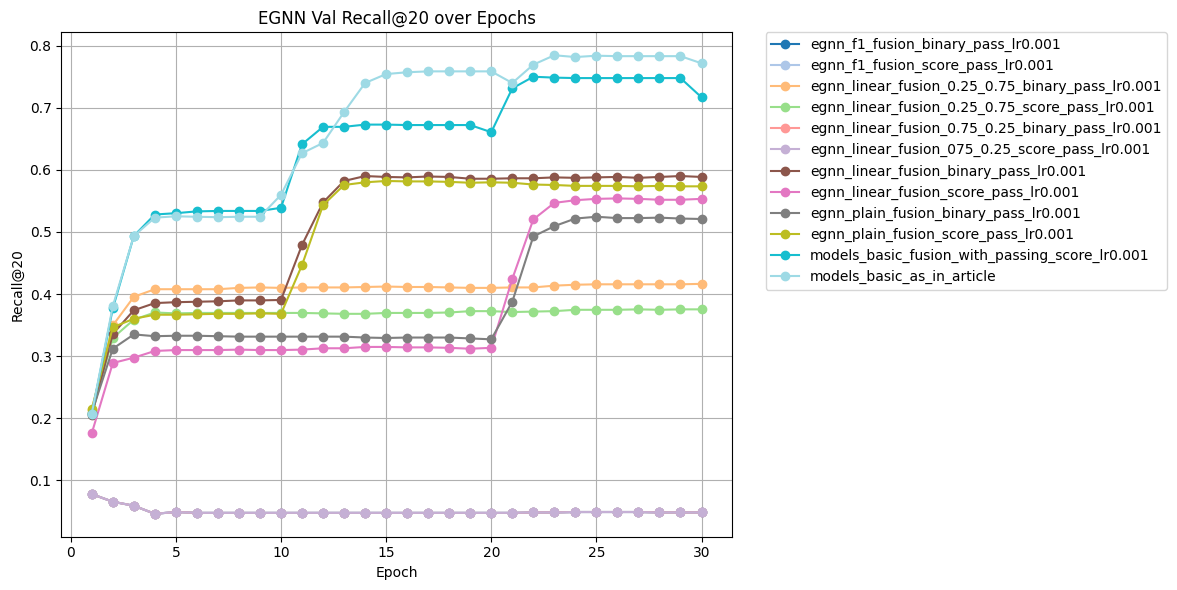

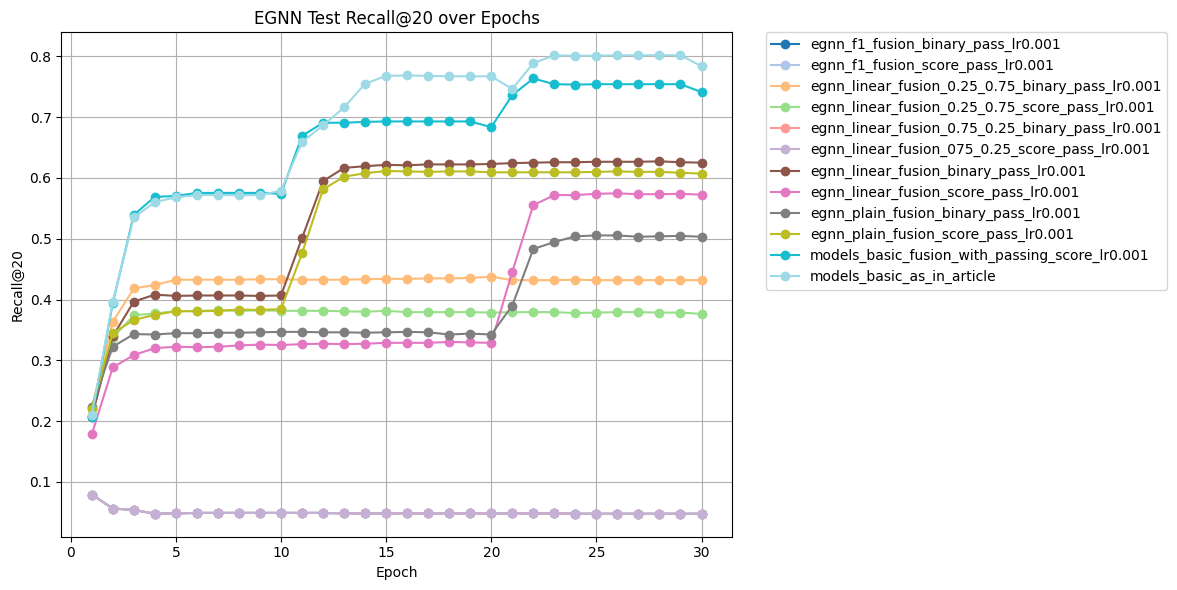

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_model_results(all_model_results, metric="val", k=20, save_path=None):
    assert metric in {"train", "val", "test"}, "Metric must be one of 'train', 'val', 'test'"

    plt.figure(figsize=(12, 6))
    
    num_lines = len(all_model_results)
    colors = plt.cm.tab20(np.linspace(0, 1, num_lines))  # tab20 gives 20 distinct colors

    for (folder, results), color in zip(all_model_results.items(), colors):
        recalls = results[metric]
        epochs = list(range(1, len(recalls) + 1))
        plt.plot(epochs, recalls, label=folder, marker='o', color=color)

    plt.xlabel("Epoch")
    plt.ylabel(f"Recall@{k}")
    plt.title(f"EGNN {metric.capitalize()} Recall@{k} over Epochs")
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"📊 Plot saved to {save_path}")
    plt.show()




plot_all_model_results(all_model_results, metric="val", k=20, save_path="./val_recall_comparison.png")
plot_all_model_results(all_model_results, metric="test", k=20)

